# Lab 1: Independent Component Analysis

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday September 17th, 16:59.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

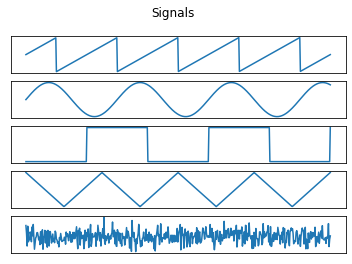

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

In [3]:
import scipy.stats

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [4]:
S_dummy = S

In [5]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    return A @ S

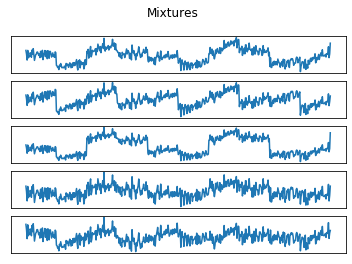

In [6]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

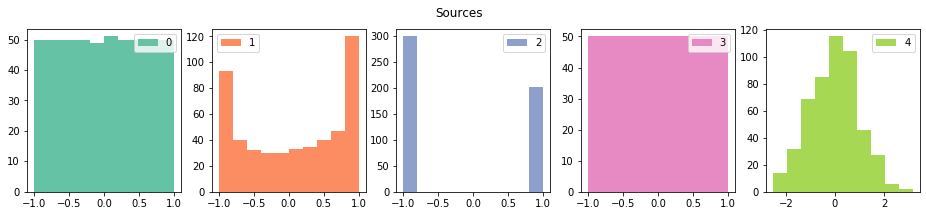

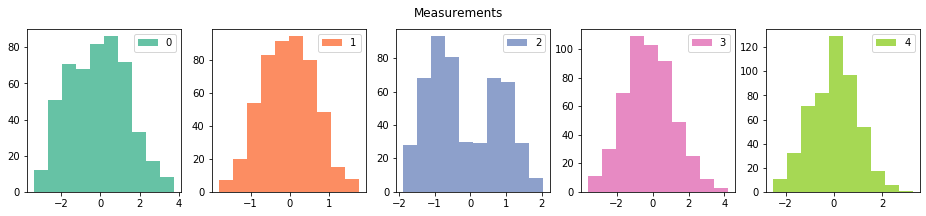

In [7]:
### 1.2 Histogram
def plot_histograms(X, title):
    fig, axs = plt.subplots(1, X.shape[0], figsize=(16,3))
    fig.suptitle(title)
    for i, ax in enumerate(axs):
        ax.hist(X[i,:], fc=plt.cm.Set2(i), label=i)
        ax.legend()
    plt.show()


plot_histograms(S, 'Sources')
plot_histograms(X, 'Measurements')

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

Of the sources the only one looking like a gaussian is the last (==random) one. This makes sense as the signal is indeed sampled under a Gaussian.

As both cosine and triangle curve have slight resemblance of a Gaussian their mixture (which will mix in from the random, normal signal) show histograms similar to one of a Gaussian.
In general it is expected that the mixture of independently distributed signals will approach a normal distribution (Central limit theorem).

It is important as an assumption of ICA is that the source distributions are not Gaussian.

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

First we fint the unnormalized prior. Then Divide by $\int p^{'}_0(a) da$ to find the normalizing factor:


$$\begin{align*}
    p_0(a) &= \frac{1}{\pi}\text{sech}(a) = \frac{1}{\pi\cosh{(a)}}\\
    p_1(a) &\propto \exp(-\frac{1}{2} a^2) \cosh{a}\\
    &= \frac{1}{\sqrt{2\pi e}} \exp(-\frac{1}{2} a^2) \cosh{a}\\
    p_2(a) &\propto \exp(-\frac{1}{4} a^4)\\
    &= \frac{\sqrt{2}}{\Gamma(\frac{1}{4})} \exp(-\frac{1}{4} a^4)\\
    p_3(a) &\propto (a^2 + 5)^{-3}\\
    &= \frac{200\sqrt{5}}{3\pi} (a^2 + 5)^{-3}
\end{align*}$$

In [8]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    return 1 / (np.pi * np.cosh(a))

In [9]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    return np.exp(- 0.5 * a**2) * np.cosh(a) / np.sqrt(2*np.pi * np.e)

In [10]:
def phi_2(a):
    return -a**3

def p_2(a):
    return np.exp(-0.25 * a**4)*np.sqrt(2)/scipy.special.gamma(0.25)

In [11]:
def phi_3(a):
    return -6*a / (a**2 + 5)

def p_3(a):
    return 1/(a**2 + 5)**3 * 200 * np.sqrt(5) / (3*np.pi)

In [12]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

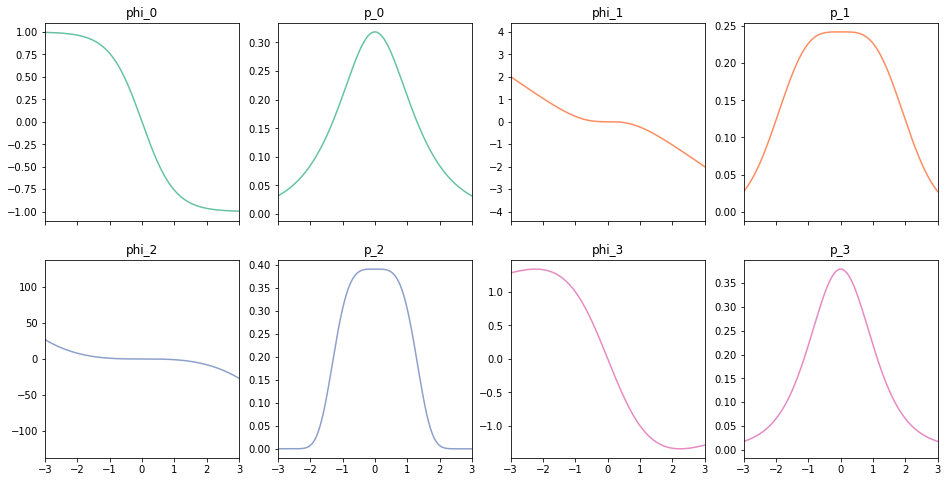

In [13]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

fig, axs = plt.subplots(2, 4, figsize=(16,8), sharex=True)
axs = axs.flatten()
for i, (ax1, ax2, act, pri) in enumerate(zip(axs[::2], axs[1::2], activation_functions, priors)):
    for ax, fn, name in ((ax1, act, 'activation'), (ax2, pri, 'prior')):
        ax.plot(a, fn(a), label=name, c=plt.cm.Set2(i))
        ax.set_title(fn.__name__)
plt.xlim(-3,3)
plt.show()

All priors show a Bell-curve-type shape similar to their measurement histograms, respectively. Exception is the square function which has a bi-modal histogram.

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [14]:
### 1.4 Whitening
def whiten(X):
    # Zero-center the data
    X -= X.mean(axis=1)[:, None]
    
    Σ = np.cov(X)
    Λ, Φ = np.linalg.eig(Σ)
    _Λ = np.diag(1/np.sqrt(Λ))
    
    return (_Λ @ Φ.T) @ X

In [15]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

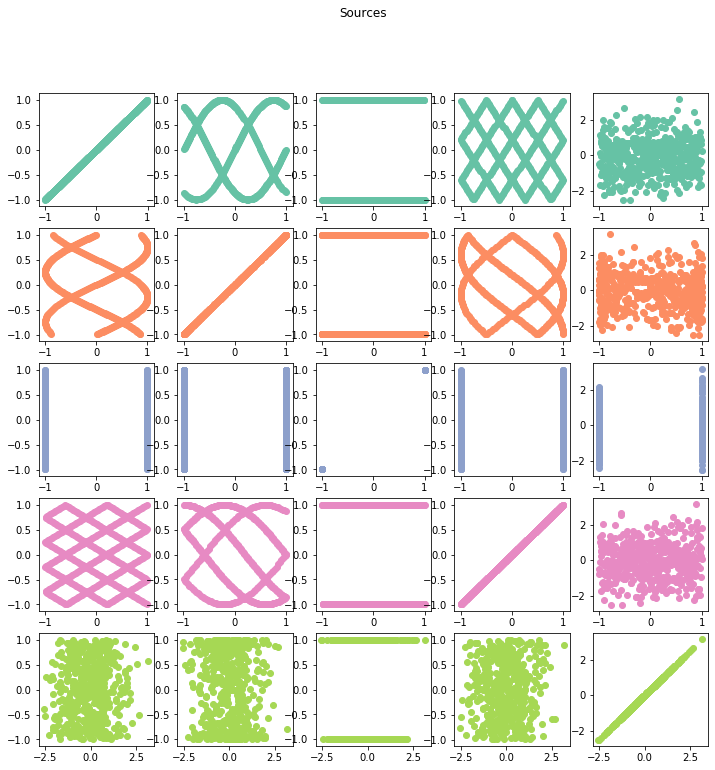

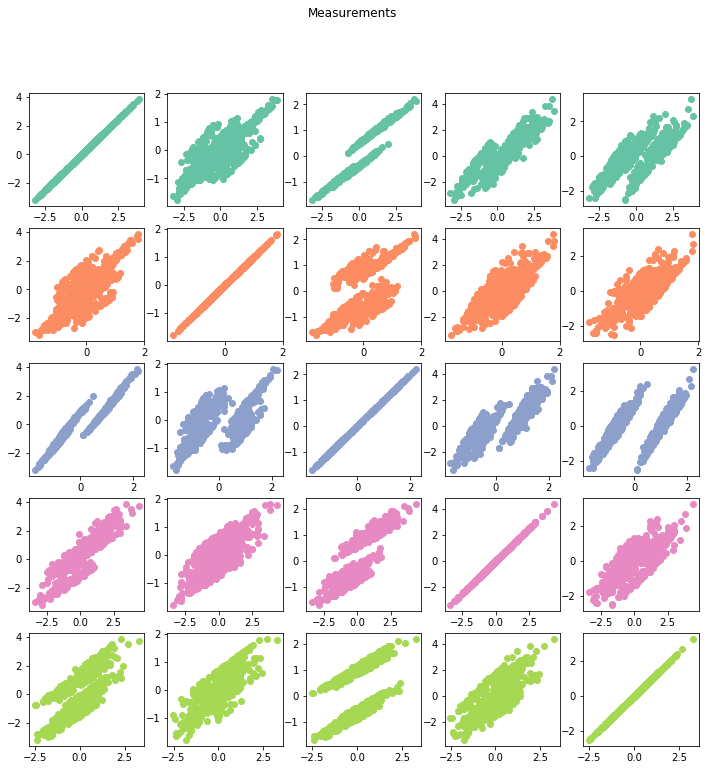

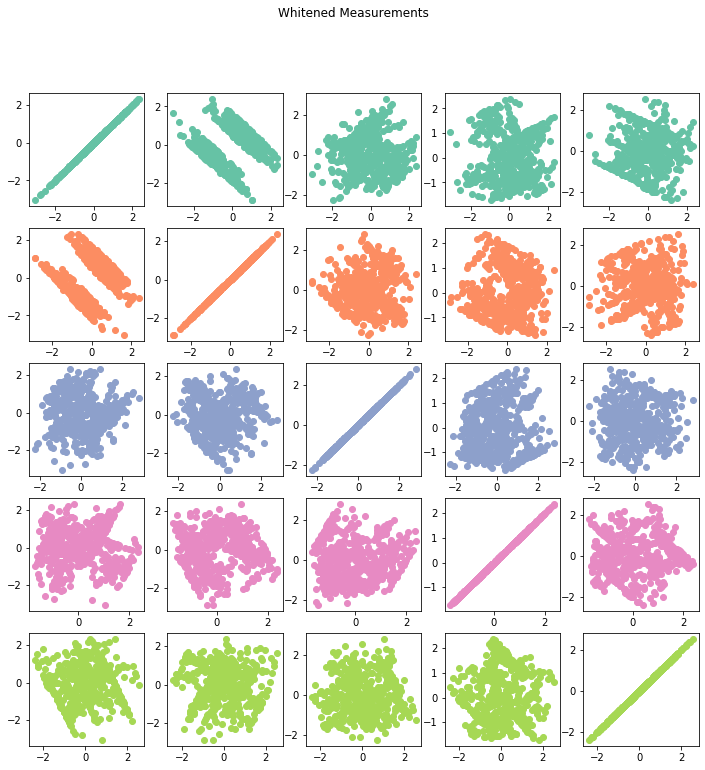

In [16]:
from itertools import product as iter_product

for dat, name in ((S, 'Sources'), (X, 'Measurements'), (Xw, 'Whitened Measurements')):
    fig, axs = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle(name)
    for i, j in iter_product(range(5),range(5)):
        axs[i,j].scatter(dat[i, :], dat[j, :], c=mpl.colors.rgb2hex(plt.cm.Set2(i)))

Are the signals independent after whitening?

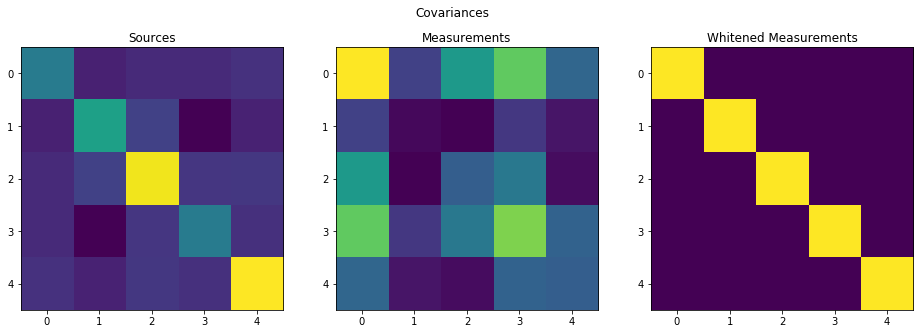

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Covariances')
for ax, (dat, name) in zip(axs, ((S, 'Sources'), (X, 'Measurements'), (Xw, 'Whitened Measurements'))):
        ax.set_title(name)
        Σ = np.cov(dat)
        ax.imshow(Σ)

We plotted the covariance matrices for the measurements and the whitened measurements. After whitening we have an identity which implies no correlation.

This does not however imply independence of the variables. If we check our pair plots, we see e.g. the pair of the signals 0 and 1 which show two clear seperated stripes of points. This structure tells us that they are not independent. Whitening is a linear operation. It does not remove higher order dependencies. Mostly they show a uniform distribution of the paired points.

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

A covariant learning algorithm is an algorithm which produces the same results under any metric scaling of the parameter weights.

For that a covariant algorithms either uses a defined metric or the curvature of the objective function. If there is a direct distance metric defined for the weight space a positive-definite scaling matrix can be derived from that which will fix the dimensionality problems in the update rule of the learning algorithm.
Alternatively one can use the curavture of the objective function and then use the inverse matrix as the scaling factor in the update rule.

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [18]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.5, print_int=100, max_int=10000, iters=False, verbose=True):
    assert callable(activation_function)
    
    W, N, i =  0.001 * random_nonsingular_matrix(X.shape[0]), X.shape[1], 0
    learning_rate *= 0.3
    while True:
        a = W @ X
        z = activation_function(a)
        x_ = W.T @ a
        ΔW = W + (z @ x_.T)/N
        W += learning_rate * ΔW
        
        tol = np.linalg.norm(ΔW)
        if verbose and i % print_int == 0:
            print(f'\r{activation_function.__name__}, Step {i:5d}: {tol:.2e} ', end='')
            sys.stdout.flush()
        if tol < 1e-5 or np.isnan(tol) or i >= max_int:
            if verbose:
                print()
            break
        i += 1
    if iters:
        return W, i
    else:
        return W

W_est = ICA(Xw, phi_3, learning_rate=1)  # Compare with ICA(X)

phi_3, Step  1200: 1.39e-05 


In [19]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])


phi_0, Step  2300: 1.22e-05 
phi_1, Step   700: 2.72e-05 
phi_2, Step   300: 3.17e-05 
phi_3, Step  1600: 1.43e-05 


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

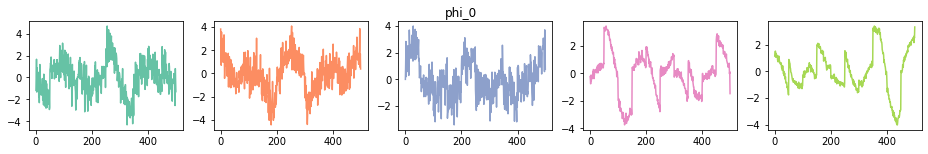

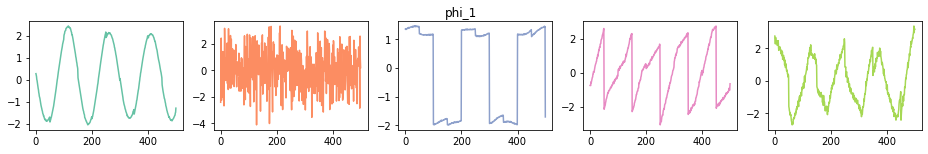

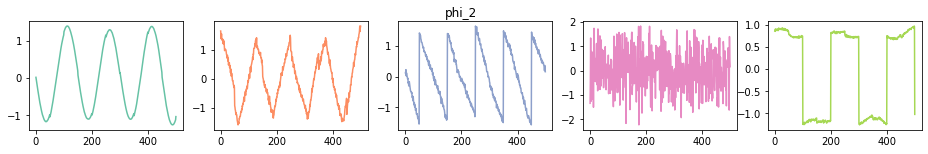

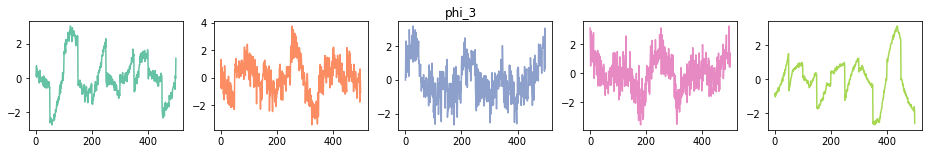

In [20]:
# 1.8 Experiments
S_dummy_de = []
for i, φ in enumerate(activation_functions):
    S_dummy_de.append(W_estimates[i] @ Xw)
    
    fig, axs = plt.subplots(1, X.shape[0], figsize=(16,2))
    fig.suptitle(φ.__name__)
    for i, ax in enumerate(axs):
        ax.plot(S_dummy_de[-1][i, :], c=plt.cm.Set2(i))

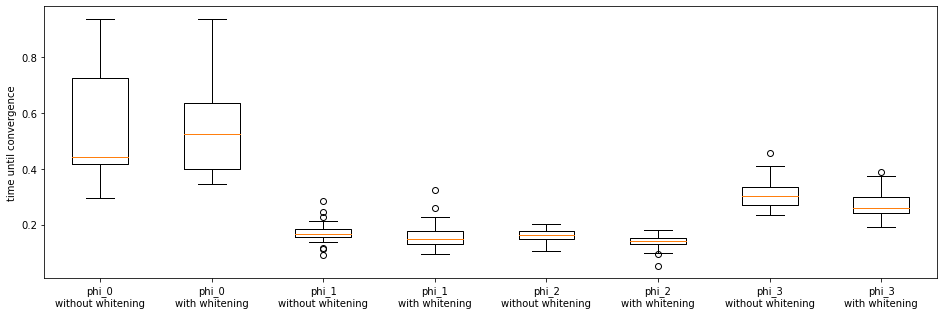

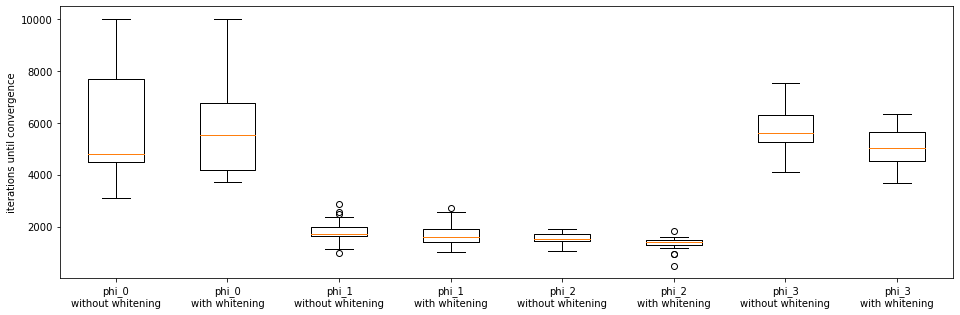

In [21]:
def whitening_box_plot():
    N = 30
    μiter = np.zeros((2, len(activation_functions), N))
    μtime = np.zeros((2, len(activation_functions), N))
    for (iφ, φ), n in iter_product(enumerate(activation_functions), range(0, N)):
        for i, _X in enumerate((X, Xw)):
            stime = time.time()
            _, μiter[i, iφ, n] = ICA(_X, activation_function=φ, learning_rate=0.3, iters=True, verbose=False)
            μtime[i, iφ, n] = time.time() - stime
            
    for data, name in ((μtime, 'time'), (μiter, 'iterations')):
        fig = plt.figure(figsize=(16, 5))
        plt.boxplot(data[0, :, :].T,
                    positions=np.arange(0, 2*len(activation_functions), 2),
                    labels=list(map(lambda x: f"{x.__name__}\nwithout whitening", activation_functions)))
        plt.boxplot(data[1, :, :].T,
                    positions=np.arange(0, 2*len(activation_functions), 2) + 1,
                    labels=list(map(lambda x: f"{x.__name__}\nwith whitening", activation_functions)))
        plt.ylabel(f"{name} until convergence")
        plt.show()
whitening_box_plot()

In [22]:
def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?    
    return False

In [23]:
assert type(does_whitening_make_a_difference()) == bool

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [24]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

Signals

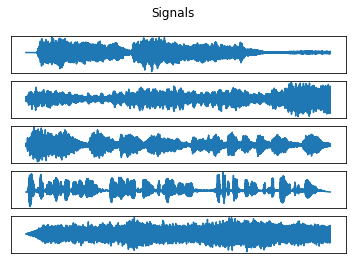

In [25]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

phi_0, Step  4900: 1.07e-05 
phi_1, Step 10000: 2.46e-05 
phi_2, Step 10000: 3.96e-03 
phi_3, Step  6400: 1.03e-05 


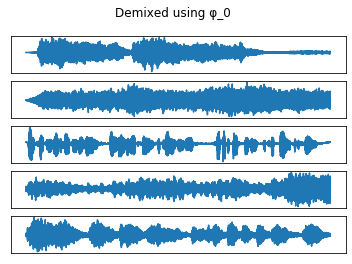

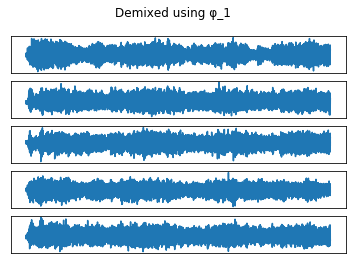

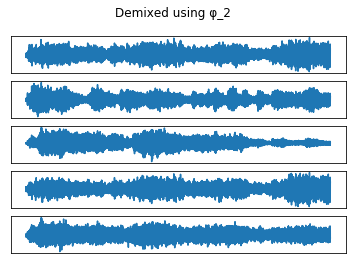

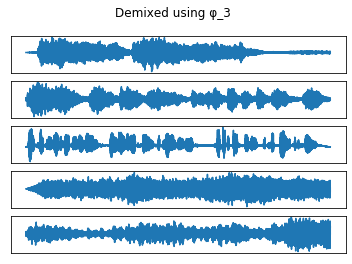

In [29]:
### 1.9 Audio demixing
A = random_nonsingular_matrix(S_audio.shape[0])
X = make_mixtures(S_audio, A)

S_audio_de = list()
for φ, η in zip(activation_functions, [2e-2, 3e-2, 1e-5, 2e-2]):
    W_est = ICA(X, φ, learning_rate=η)
    S_audio_de.append(W_est @ X)
    
for i, s in enumerate(S_audio_de):
    plot_signals(s, f"Demixed using φ_{i}")

In [30]:
play_signals(S_audio_de[0], sample_rate)

Signals

## Report your results. Using which activation functions ICA recovers the sources?

Setting the learning rate $\eta$ specifically we can make ICA converge for all four activation functions. As such they all can recover the sources.

Under our artifical maximum iteration number of 10.000 $\phi_0$ and $\phi_3$ converge.

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

$$
\begin{align*}
    p_0(a)
    &= \frac{1}{\pi\cosh(a)}\\
    &\Rightarrow\\
    \text{Kurt}[p_0(x)]
    &= \frac{\int \frac{a^4}{\pi \cosh a} da}{[\int \frac{a^2}{\pi\cosh a} da]^2} - 3\\
    &= (\frac{5\pi^4}{16}{(\frac{4}{\pi^2})}^2) - 3\\
    &= 2
\end{align*}
$$

$$
\begin{align*}
    p_1(a)
    &= \frac{1}{\sqrt{\pi e}}\exp{(-\frac{1}{2}a^2)}\cosh(a)\\
    &\Rightarrow\\
    \text{Kurt}[p_1(x)]
    &= \frac{\int a^4 \frac{1}{\sqrt{\pi e}}\exp{(-\frac{1}{2}a^2)}\cosh(a) da}{{[\int \frac{1}{\sqrt{\pi e}}\exp{(-\frac{1}{2}a^2)}\cosh(a) da]}^2} - 3\\
    &= \frac{10}{2^2} - 3\\
    &= - \frac{1}{2}
\end{align*}
$$

$$
\begin{align*}
    p_2(a)
    &= \frac{\sqrt{2}}{\Gamma{(\frac{1}{4})}}\exp{(-\frac{1}{4}a^4)}\\
    &\Rightarrow\\
    \text{Kurt}[p_2(x)]
    &= \frac{\int a^4 \frac{\sqrt{2}}{\Gamma{(\frac{1}{4})}}\exp{(-\frac{1}{4}a^4)} da }{{[\int a^2 \frac{\sqrt{2}}{\Gamma{(\frac{1}{4})}}\exp{(-\frac{1}{4}a^4)} da]}^2} - 3\\
    &= 1\cdot{[\frac{\Gamma{(\frac{1}{4})}}{2\Gamma{(\frac{3}{4})}}]}^2 - 3\\
    &\approx -0.8116
\end{align*}
$$

$$
\begin{align*}
    p_3(a)
    &= \frac{200\cdot\sqrt{5}}{3\pi{(a^2 + 5)}^3}\\
    &\Rightarrow\\
    \text{Kurt}[p_3(x)]
    &= \frac{\int a^4 \frac{200\cdot\sqrt{5}}{3\pi{(a^2 + 5)}^3} da}{{[\int a^2 \frac{200\cdot\sqrt{5}}{3\pi{(a^2 + 5)}^3} da]}^2} - 3\\
    &= \frac{25}{{(\frac{5}{3})}^2} - 3\\
    &= 6
\end{align*}
$$

In [31]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    return [
        2,
        -0.5,
        (scipy.special.gamma(1/4)/(2*scipy.special.gamma(3/4)))**2 - 3,
        6
    ]

In [32]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


[2, -0.5, -0.8115603847735229, 6]


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

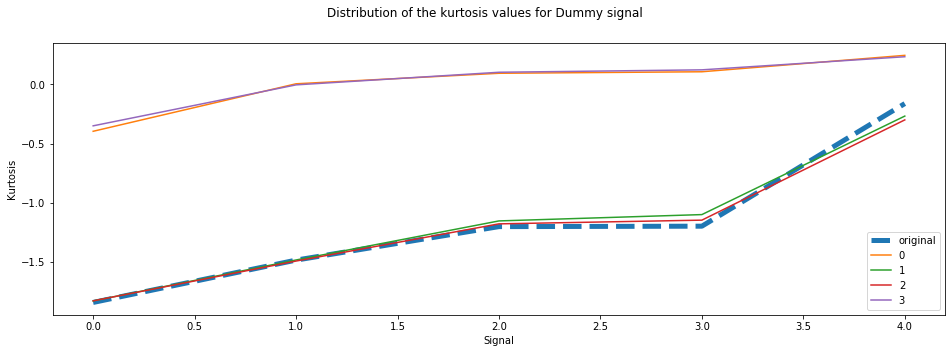

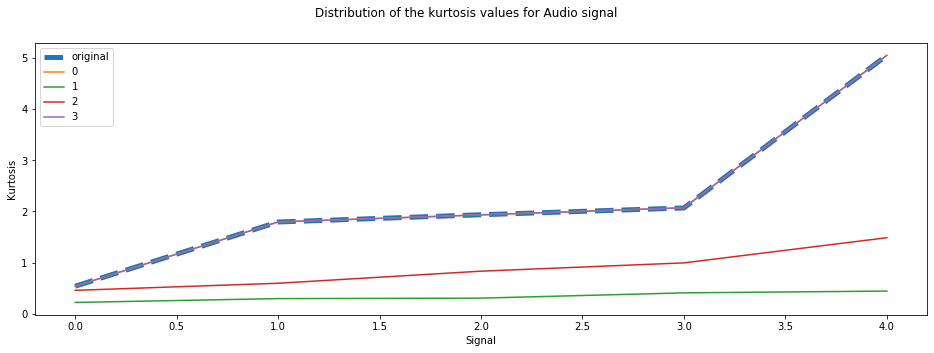

In [35]:
### 1.10.2 Excess Kurtosis
def kurt_plot(S, S_de, title):
    def emp_kurt(_S):
        return sorted(scipy.stats.kurtosis(_S.T, fisher=True))
    
    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(f"Distribution of the kurtosis values for {title}")
    plt.plot(emp_kurt(S), '--', label='original', lw=5)
    for i in range(len(activation_functions)):
            plt.plot(emp_kurt(S_de[i]), label=i)
    plt.xlabel('Signal')
    plt.ylabel('Kurtosis')
    plt.legend()
    
kurt_plot(S_dummy, S_dummy_de, 'Dummy signal')
kurt_plot(S_audio, S_audio_de, 'Audio signal')

Inspecting the graphs the denoised reconstructions that have similar Kurtosis curves to the original signal.

For the dummy signal we see that $\phi_1$ and $\phi_2$ led gave Kurosis values similar to the original while $\phi_0$ and $\phi_3$ deviate strongly from it.
For the audio signal the evidence is reveresed. $\phi_0$ and $\phi_3$ reconstruct with similar values while $\phi_1$ and $\phi_2$ are strongly different to the original.

If the Kurtosis values are different to the original we know that the reconstruction can not be similar while having similar values only gives us an indication of success. As it is just one moment of the distribution it is not enough to compare results.



Activation function $\phi_1$ and $\phi_2$ are wider while $\phi_0$ and $\phi_3$ are spikey. The dummy data has not as many high frequency features as the audio signals. Thats why the dummy data is better reconstructed with the wider activation functions.